# Graph reports
## Import Data

In [138]:
import datetime
import gc
import math
import re

import matplotlib.pyplot as plt
import pandas
import scipy
import seaborn as sns

# read dataset from json file
# dataset = pandas.read_json("../data/split/characters/characters1.json")
datasetCharacters = pandas.read_json("../data/characters.json")
datasetCharacters.index = datasetCharacters.id
print('Characters imported: ', len(datasetCharacters))
datasetMedias = pandas.read_json("../data/medias.json")
datasetMedias.index = datasetMedias.id
print('Medias imported: ', len(datasetMedias))
datasetStaffs = pandas.read_json("../data/staffs.json")
datasetStaffs.index = datasetStaffs.id
print('Staffs imported: ', len(datasetStaffs))
datasetStudios = pandas.read_json("../data/studios.json")
print('Studios imported: ', len(datasetStudios))
gc.collect()
print('setup up complete')

Characters imported:  129047
Medias imported:  104261
Staffs imported:  120854
Studios imported:  1923
setup up complete


## Sample Chart Distributions of characters over Months of the year

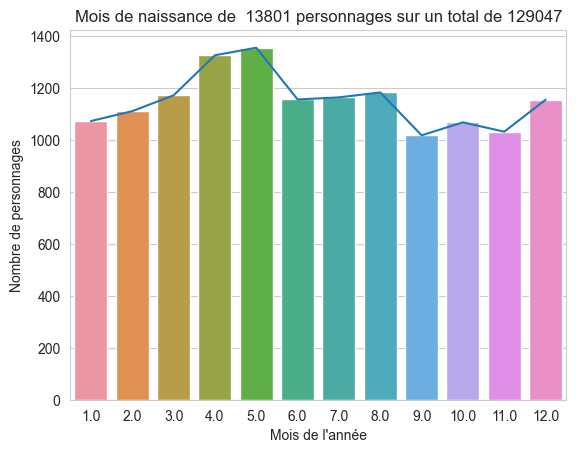

count      12.000000
mean     1150.083333
std       104.593984
min      1017.000000
25%      1070.750000
50%      1154.500000
75%      1173.750000
max      1354.000000
Name: dateOfBirthMonth, dtype: float64

In [187]:
# Flatten dateOfBirth.month object in new column in the dataset
all_months_count = []
for index, character in datasetCharacters.iterrows():
    all_months_count.append(character['dateOfBirth']['month'])

datasetCharacters['dateOfBirthMonth'] = all_months_count

# Count values of month (None value are excluded)
datasetMonthValueCount = datasetCharacters.dateOfBirthMonth.value_counts()

# Line plot
# sns.lineplot(data=datasetMonthValueCount) # if printed alone
sns.lineplot(x=datasetMonthValueCount.index - 1, y=datasetMonthValueCount.values)

# Bar plot
sns.barplot(x=datasetMonthValueCount.index, y=datasetMonthValueCount.values)

# Adding label description
plt.xlabel('Mois de l\'année')
plt.ylabel('Nombre de personnages')
plt.title(f'Mois de naissance de  {sum(datasetMonthValueCount.values)} '
          f'personnages sur un total de {len(all_months_count)}')
plt.show()
datasetMonthValueCount.describe()


## Util functions

In [140]:
# function used to extract age of character from string
# example 25-29
def find_avg_sum_in_string(paramString):
    if paramString is None: return None
    numberList = re.findall("[0-9]+", paramString)
    numberListAsInt = [int(n) for n in numberList if n]
    average = sum(numberListAsInt) / float(len(numberListAsInt)) if numberListAsInt else None
    return average


print(find_avg_sum_in_string(None))
print(find_avg_sum_in_string("25 - 27"))
print(find_avg_sum_in_string("15 (Series); 16 (Movie)"))

None
26.0
15.5


In [141]:
# date of media lunch is seasonYear and month related to season string
#  WINTER=1, SPRING=4, SUMMER=7, FALL=10
seasonToMonth = {
    "WINTER": 1,
    "SPRING": 4,
    "SUMMER": 7,
    "FALL": 10,
}
# calculating staff age at lunch of the media
def get_age_of_staff_at_media_lunch(staffDateOfBirthDict, mediaSeasonYear, mediaSeason):
    if staffDateOfBirthDict['year'] is not None \
            and staffDateOfBirthDict['year'] < 2022 \
            and not math.isnan(mediaSeasonYear):
        month = staffDateOfBirthDict['month'] if staffDateOfBirthDict['month'] else 1
        month = month if 1 <= month <= 12 else 6
        day = staffDateOfBirthDict['day'] if staffDateOfBirthDict['day'] else 1
        staffDateOfBirth = datetime.date(staffDateOfBirthDict['year'], month, day)
        mediaLunchDate = datetime.date(math.ceil(mediaSeasonYear), seasonToMonth[mediaSeason], 1)
        staffAgeAtMediaLunch = (mediaLunchDate - staffDateOfBirth).days / 365.2425
    else:
        mediaLunchDate = None
        staffAgeAtMediaLunch = None
    return mediaLunchDate, staffAgeAtMediaLunch

staffDateOfBirthDict = {'year': 1990, 'month': 1, 'day': 1}
mediaSeasonYear = 2010
mediaSeason = 'WINTER'
mediaLunchDate, staffAgeAtMediaLunch = get_age_of_staff_at_media_lunch(staffDateOfBirthDict, mediaSeasonYear, mediaSeason)
print(mediaLunchDate, staffAgeAtMediaLunch)

2010-01-01 20.000410686051048


## Create Staff - Character - Media relations

In [147]:
# staffId, characterId, mediaId,
staffIds = []
characterIds = []
mediaIds = []

# birthdates related columns
staffBirthDateDays = []
staffBirthDateMonths = []
characterBirthDateDays = []
characterBirthDateMonths = []

# ages related columns
mediaLunchDates = []
staffAgesAtMediaLunch = []
characterAges = []

# gender related columns
staffGenders = []
characterGenders = []

# blood type related columns
staffBloodType = []
characterBloodType = []



for index, staff in datasetStaffs.iterrows():
    characterEdges = {}
    for characterEdge in staff['characters']['edges']:
        characterEdges[characterEdge['id']] = characterEdge
        # access character id by: characterEdge['node']['id']

    mediaEdges = {}
    for mediaEdge in staff['characterMedia']['edges']:
        mediaEdges[mediaEdge['id']] = mediaEdge
        # access media id by : mediaEdge['node']['id']

    for edgeId in characterEdges.keys():
        if edgeId not in mediaEdges.keys():
            continue
        staffId = staff['id']
        characterId = characterEdges[edgeId]['node']['id']
        mediaId = mediaEdges[edgeId]['node']['id']
        if characterId not in datasetCharacters.index or mediaId not in datasetMedias.index:
            continue

        character = datasetCharacters.loc[characterId]
        media = datasetMedias.loc[mediaId]

        # now all entities are well defined: "staff" doubling "character" in "media"
        # appending data to columns
        staffIds.append(staffId)
        characterIds.append(characterId)
        mediaIds.append(mediaId)

        # birthdates related columns
        staffDateOfBirthDict = staff['dateOfBirth']
        characterDateOfBirthDict = character['dateOfBirth']

        staffBirthDateDays.append(staffDateOfBirthDict['day'])
        staffBirthDateMonths.append(staffDateOfBirthDict['month'])
        characterBirthDateDays.append(characterDateOfBirthDict['day'])
        characterBirthDateMonths.append(characterDateOfBirthDict['month'])

        # ages related columns
        mediaLunchDate, staffAgeAtMediaLunch = \
            get_age_of_staff_at_media_lunch(staffDateOfBirthDict, media.seasonYear, media.season)
        mediaLunchDates.append(mediaLunchDate)
        staffAgesAtMediaLunch.append(staffAgeAtMediaLunch)
        characterAges.append(find_avg_sum_in_string(character['age']))

        # sex related columns
        staffGenders.append(staff['gender'])
        characterGenders.append(character['gender'])

        # blood type related columns
        staffBloodType.append(staff['bloodType'])
        characterBloodType.append(character['bloodType'])
print("Relations create complete: ", len(staffIds))

Relations create complete:  112207


In [149]:
# Group all results in DataFrame
aioStaffCharacterRelations = pandas.DataFrame();
aioStaffCharacterRelations['staffIds'] = staffIds
aioStaffCharacterRelations['characterIds'] = characterIds
aioStaffCharacterRelations['mediaIds'] = mediaIds
# birthdates related columns
aioStaffCharacterRelations['staffBirthDateDays'] = staffBirthDateDays
aioStaffCharacterRelations['staffBirthDateMonths'] = staffBirthDateMonths
aioStaffCharacterRelations['characterBirthDateDays'] = characterBirthDateDays
aioStaffCharacterRelations['characterBirthDateMonths'] = characterBirthDateMonths

# ages related columns
aioStaffCharacterRelations['mediaLunchDates'] = mediaLunchDates
aioStaffCharacterRelations['staffAgesAtMediaLunch'] = staffAgesAtMediaLunch
aioStaffCharacterRelations['characterAges'] = characterAges

# sex related columns
aioStaffCharacterRelations['staffGenders'] = staffGenders
aioStaffCharacterRelations['characterGenders'] = characterGenders

# blood type related columns
aioStaffCharacterRelations['staffBloodType'] = staffBloodType
aioStaffCharacterRelations['characterBloodType'] = characterBloodType

aioStaffCharacterRelations

,staffIds,characterIds,mediaIds,staffBirthDateDays,staffBirthDateMonths,characterBirthDateDays,characterBirthDateMonths,mediaLunchDates,staffAgesAtMediaLunch,characterAges,staffGenders,characterGenders,staffBloodType,characterBloodType
0,95001,209,120,8.0,9.0,NaN,NaN,2001-07-01,28.810995,17.0,Male,Male,AB,A
1,95001,68315,13601,8.0,9.0,16.0,8.0,2012-10-01,40.063793,28.0,Male,Male,AB,None
2,95001,35258,9253,8.0,9.0,19.0,5.0,2011-04-01,38.560682,19.0,Male,Male,AB,B
3,95001,6296,9201,8.0,9.0,NaN,NaN,2010-10-01,38.062383,NaN,Male,None,AB,None
4,95001,4087,230,8.0,9.0,NaN,NaN,2003-04-01,30.560518,NaN,Male,None,AB,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112202,295325,130796,7695,NaN,NaN,NaN,NaN,2010-07-01,56.496711,NaN,Male,None,None,None
112203,295334,135830,20992,28.0,3.0,NaN,NaN,2015-10-01,19.510325,16.0,Male,None,None,None
112204,295335,141763,21879,NaN,NaN,2.0,4.0,None,NaN,NaN,Male,Male,None,None
112205,295347,49343,155011,NaN,NaN,NaN,NaN,None,NaN,NaN,Male,None,None,None


## BirthDates Analysis

                          staffBirthDateDays  staffBirthDateMonths  \
staffBirthDateDays                  1.000000             -0.041249   
staffBirthDateMonths               -0.041249              1.000000   
characterBirthDateDays              0.012074              0.006571   
characterBirthDateMonths           -0.004506              0.015597   

                          characterBirthDateDays  characterBirthDateMonths  
staffBirthDateDays                      0.012074                 -0.004506  
staffBirthDateMonths                    0.006571                  0.015597  
characterBirthDateDays                  1.000000                  0.071418  
characterBirthDateMonths                0.071418                  1.000000  


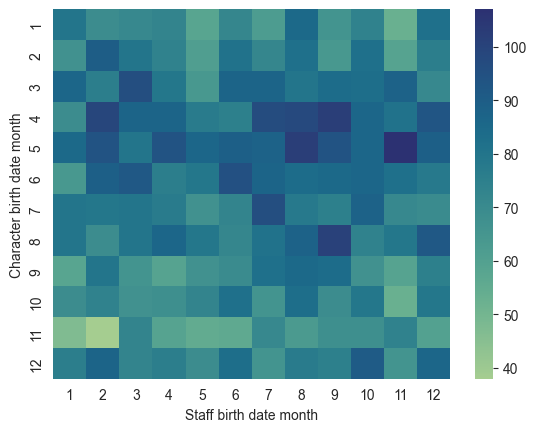

staffBirthDateDays          11142
staffBirthDateMonths        11142
characterBirthDateDays      11142
characterBirthDateMonths    11142
dtype: int64

In [150]:
birthDatesColumns = [
    'staffBirthDateDays',
    'staffBirthDateMonths',
    'characterBirthDateDays',
    'characterBirthDateMonths',
]
birthDateAnalysis = aioStaffCharacterRelations[birthDatesColumns].dropna().convert_dtypes()
birthDateMonthsCross = pandas.crosstab(birthDateAnalysis['characterBirthDateMonths'], birthDateAnalysis['staffBirthDateMonths'])
print(birthDateAnalysis.corr())
ax = sns.heatmap(birthDateMonthsCross, cmap="crest")
plt.xlabel("Staff birth date month")
plt.ylabel("Character birth date month")
plt.show()
birthDateAnalysis.count()

## Gender Analysis

In [151]:
genderColumns = ['staffGenders', 'characterGenders']
gendersTypes = ['Male', 'Female']
genderAnalysis = aioStaffCharacterRelations[genderColumns].dropna()
genderAnalysis = genderAnalysis[genderAnalysis['staffGenders'].isin(gendersTypes)]
genderAnalysis = genderAnalysis[genderAnalysis['characterGenders'].isin(gendersTypes)]
pandas.crosstab(genderAnalysis['staffGenders'], genderAnalysis['characterGenders'], margins=True)


characterGenders,Female,Male,All
staffGenders,,,
Female,13504,1332,14836
Male,76,14518,14594
All,13580,15850,29430


### Female staff To Male Character Analysis (kids ??)

In [152]:
genderAnalysisFemelleStaffToMale = genderAnalysis[genderAnalysis['staffGenders'] == 'Female']
genderAnalysisFemelleStaffToMale = genderAnalysisFemelleStaffToMale[
    genderAnalysisFemelleStaffToMale['characterGenders'] == 'Male']
# later make age comparision of these one
print("set prepared, see Age - Female To Male section below ")

set prepared, see Age - Female To Male section below 


## Age analysis

                       characterAges  staffAgesAtMediaLunch
characterAges               1.000000               0.574728
staffAgesAtMediaLunch       0.574728               1.000000
       characterAges  staffAgesAtMediaLunch
count    7199.000000            7199.000000
mean       21.807430              31.638551
std        11.759488               9.768778
min         2.000000              18.007214
25%        15.500000              24.894419
50%        17.000000              29.385956
75%        25.000000              35.614694
max        99.000000              86.454890


<AxesSubplot: xlabel='Âge des doubleurs au moment de la sortie du média', ylabel='Âge des personnages'>

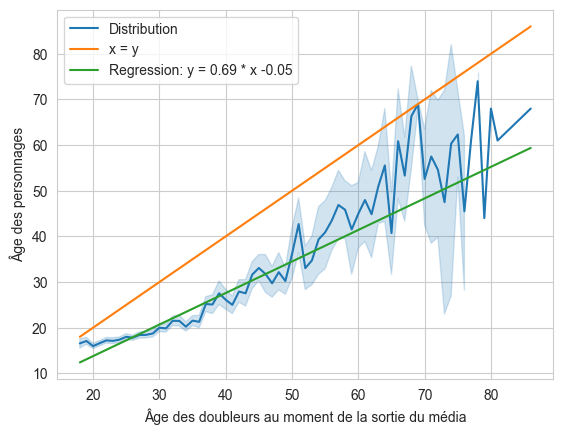

In [153]:
ageColumns = ['characterAges', 'staffAgesAtMediaLunch']
ageAnalysis = aioStaffCharacterRelations[ageColumns].dropna()
ageAnalysis = ageAnalysis[ageAnalysis['staffAgesAtMediaLunch'] < 100]
ageAnalysis = ageAnalysis[ageAnalysis['staffAgesAtMediaLunch'] > 18]
ageAnalysis = ageAnalysis[ageAnalysis['characterAges'] < 100]
ageAnalysis = ageAnalysis[ageAnalysis['characterAges'] > 1]
print(ageAnalysis.corr())
print(ageAnalysis.describe())
ageAnalysis['staffAgesAtMediaLunch'] = ageAnalysis['staffAgesAtMediaLunch'].apply(lambda x: round(x))
plt.xlabel("Âge des doubleurs au moment de la sortie du média")
plt.ylabel("Âge des personnages")
sns.lineplot(x=ageAnalysis['staffAgesAtMediaLunch'], y=ageAnalysis['characterAges'], label='Distribution')
sns.lineplot(x=ageAnalysis['staffAgesAtMediaLunch'], y=ageAnalysis['staffAgesAtMediaLunch'],
             label='x = y')

# fitted line
res = scipy.stats.linregress(x=ageAnalysis['staffAgesAtMediaLunch'], y=ageAnalysis['characterAges'])
sns.lineplot(x=ageAnalysis['staffAgesAtMediaLunch'],
             y=res.intercept + res.slope * ageAnalysis['staffAgesAtMediaLunch'],
             label=f'Regression: y = {round(res.slope, 2)} * x {round(res.intercept, 2)}')


### Age - Gender Staff Female to Male analysis (Kids???)

count    7199.000000
mean       21.807430
std        11.759488
min         2.000000
25%        15.500000
50%        17.000000
75%        25.000000
max        99.000000
Name: characterAges, dtype: float64

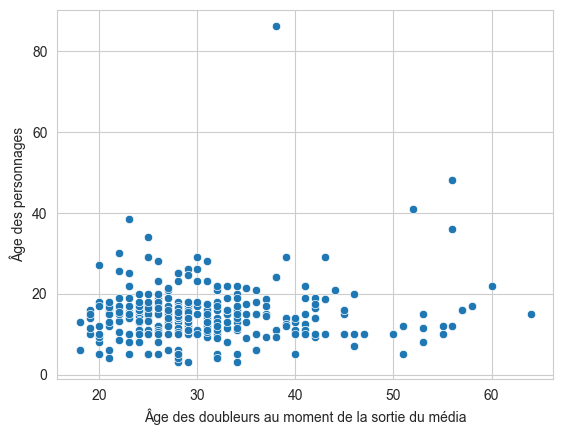

In [154]:
ageGenderAnalysisFemelleStaffToMale = ageAnalysis[ageAnalysis.index.isin(genderAnalysisFemelleStaffToMale.index)]
plt.xlabel("Âge des doubleurs au moment de la sortie du média")
plt.ylabel("Âge des personnages")
sns.scatterplot(x=ageGenderAnalysisFemelleStaffToMale['staffAgesAtMediaLunch'],
                y=ageGenderAnalysisFemelleStaffToMale['characterAges'])
ageAnalysis['characterAges'].describe()

In [286]:
len(datasetStaffs)

120854

## Blood Type Analysis

In [155]:
bloodTypeColumns = [
    'staffBloodType',
    'characterBloodType',
]
bloodTypes = [
    "A", "O", "B", "AB"
]
bloodTypeAnalysis = aioStaffCharacterRelations[bloodTypeColumns].applymap(lambda x: re.sub("[+-.]", "", x) if x else None)
bloodTypeBothDefined = bloodTypeAnalysis[bloodTypeAnalysis['characterBloodType'].isin(bloodTypes)]
bloodTypeBothDefined = bloodTypeBothDefined[bloodTypeBothDefined['staffBloodType'].isin(bloodTypes)]
print(bloodTypeAnalysis.describe())
display(bloodTypeAnalysis[bloodTypeAnalysis['staffBloodType'].isin(bloodTypes)]['staffBloodType'].value_counts())
display(bloodTypeAnalysis[bloodTypeAnalysis['characterBloodType'].isin(bloodTypes)]['characterBloodType'].value_counts())
pandas.crosstab(bloodTypeBothDefined['staffBloodType'], bloodTypeBothDefined['characterBloodType'], margins=True)



       staffBloodType characterBloodType
count           18739               6920
unique             13                 83
top                 A                  A
freq             6798               1920


A     6798
O     5691
B     4071
AB    2150
Name: staffBloodType, dtype: int64

A     1920
O     1607
B     1324
AB    1089
Name: characterBloodType, dtype: int64

characterBloodType,A,AB,B,O,All
staffBloodType,,,,,
A,92,67,75,98,332
AB,39,15,25,26,105
B,66,35,51,45,197
O,84,41,57,71,253
All,281,158,208,240,887


## Age of the team a media lunch (same ages ???)

In [156]:
teamAgeColumns = ['mediaIds', 'staffIds', 'staffAgesAtMediaLunch']
groupedByMediaStaffId = aioStaffCharacterRelations[teamAgeColumns].groupby(['mediaIds', 'staffIds']).mean()

allDescribes = {}
groupedByMediaStaffId.reset_index(inplace=True)
for mediaId in groupedByMediaStaffId['mediaIds'].unique():
    filteredOneMedia = groupedByMediaStaffId[groupedByMediaStaffId['mediaIds'] == mediaId]
    allDescribes[mediaId] = filteredOneMedia['staffAgesAtMediaLunch'].describe()
print("setup complete")

setup complete


In [282]:
allDescribesPd = pandas.DataFrame(allDescribes).transpose().dropna()
# prendre les medias ou le minimum d'age des doubleurs est plus grand que 10
allDescribesPd = allDescribesPd[allDescribesPd['min'] > 10]
allDescribesPd = allDescribesPd[allDescribesPd['std'] < 30]


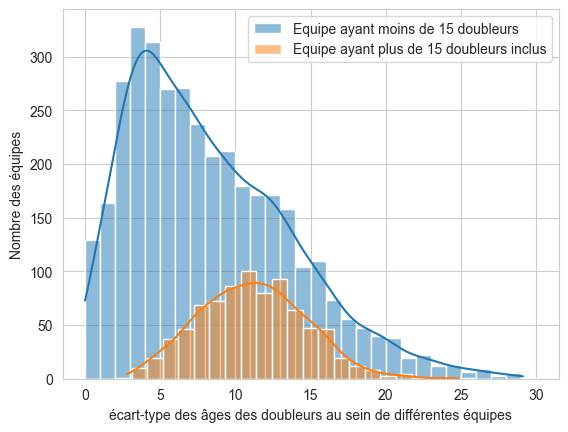

             count         mean          std          min          25%  \
count  3648.000000  3648.000000  3648.000000  3648.000000  3648.000000   
mean      5.556743    32.664176     8.350949    23.848171    28.026259   
std       3.371368     7.584886     5.423764     6.700298     6.641387   
min       2.000000    13.932296     0.001936    10.026215    10.578588   
25%       3.000000    27.219745     4.049874    19.748523    23.784540   
50%       5.000000    31.366010     7.290948    23.284530    26.875295   
75%       8.000000    36.878662    11.886734    26.927315    30.949301   
max      14.000000    74.105560    29.130881    71.248554    72.677057   

               50%          75%          max  
count  3648.000000  3648.000000  3648.000000  
mean     31.708662    36.414151    44.091962  
std       7.854001     9.698640    13.949851  
min      10.847588    14.228218    14.535548  
25%      26.395819    29.208676    32.598205  
50%      29.958178    34.300499    41.482029  
75% 

In [284]:
plt.xlabel('écart-type des âges des doubleurs au sein de différentes équipes')
plt.ylabel("Nombre des équipes")

allDescribesPdSmall = allDescribesPd[allDescribesPd['count'] < 15]
allDescribesPdBig = allDescribesPd[allDescribesPd['count'] >= 15]

test = sns.histplot(x = allDescribesPdSmall['std'], binrange=[0,30], label='Equipe ayant moins de 15 doubleurs', kde=True, color=sns.color_palette()[0])

sns.histplot(x = allDescribesPdBig['std'], binrange=[0,30], label='Equipe ayant plus de 15 doubleurs inclus', kde=True, color=sns.color_palette()[1])
plt.legend()
plt.show()
print(allDescribesPdSmall.describe())
print(allDescribesPdBig.describe())

## Graph staffs <-> staffs
### importing data

In [159]:
import gc
import warnings
import plotly.graph_objects as go

import networkx as nx
import pandas
from pandas import json_normalize

# https://plotly.com/python/network-graphs/
# read dataset from json file
# https://github.com/catboost/catboost/issues/2179
warnings.simplefilter(action='ignore', category=FutureWarning)
print("clearing memory")
datasetMedias = None
datasetStaffs = None
gc.collect()
print("reading medias")
datasetMedias = pandas.read_json("../data/medias.json")
print("reading medias complete " + str(len(datasetMedias)) + " entries")
print("reading staffs")
datasetStaffs = pandas.read_json("../data/staffs.json")
print("reading staffs complete " + str(len(datasetStaffs)) + " entries")
print("import complete")

clearing memory
reading medias
reading medias complete 104261 entries
reading staffs
reading staffs complete 120854 entries
import complete


### Prepare Data to be filtered
we have media title as embeded object in dataframe column title in form of
```graphql
      media {
          title {
            romaji
            english
            native
            userPreferred
          }
      }
```
so will flatten title into 4 new columns prefixed with ''title_'' to be in form of
```graphql
      media {
            title_romaji
            title_english
            title_native
            title_userPreferred
      }
```

In [ ]:
titles = json_normalize(datasetMedias['title'].tolist()).add_prefix('title_')
if len(datasetMedias.filter(like="title_").columns) == 0:
    datasetMedias = titles.join(datasetMedias)
else:
    print("Already flattened")

datasetMedias.index = datasetMedias.id
datasetStaffs.index = datasetStaffs.id
titles.index = datasetMedias.index

display(datasetMedias.head(1))
print("preparation complete")

### Filter data
To form our graph, we will target a specific media using search.
We get the first media found and collect all its related media (usually series or sequel if exist)

In [ ]:
# Get only medias related to specific animation
nameOfAnimation = "One piece"
# search media titles ignoring case and ignoring none value
targetMedia = datasetMedias[titles.title_english.str.contains(nameOfAnimation, na=False, case=False)]

if len(targetMedia) == 0:
    print("no media with such name was found")
    exit()

# get the first media found
firstMediaFound = targetMedia.loc[targetMedia.index[0]]
#  use relations attributes to collect others related medias in series
# relations -> nodes -> [{"id":value}]
# extract relations nodes id to list
targetRelatedMediasIds = pandas.DataFrame(firstMediaFound.relations['nodes']).id.to_list()
targetRelatedMediasIds.append(firstMediaFound.id)
targetMedias = datasetMedias[datasetMedias.id.isin(targetRelatedMediasIds)]

if len(targetRelatedMediasIds) != len(targetMedias):
    print("Media node ids " + str(list(set(targetRelatedMediasIds) - set(targetMedias.id)))
          + " was not found in dataset")

print("Media input search: " + nameOfAnimation)
print("Media found: " + firstMediaFound.title_english)
print("Related medias count: " + str(len(targetMedias)))

display(targetMedias)
print("setup complete")


### Creating graphs
Each media form a complete graph connecting its staffs together.
When adding medias if nodes exist we add 1 to weight


In [ ]:
targetMedias.loc[21]['staff']['edges'][0]['node']['id']

In [285]:
# create graph
G = nx.Graph()
for index, media in targetMedias.iterrows():
    nodes = media['staff']['edges']
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            a = nodes[i]['node']['id']
            b = nodes[j]['node']['id']
            if not G.has_edge(a, b):
                G.add_edge(a, b, weight=1)
            else:
                G.add_edge(a, b, weight=G.get_edge_data(a, b)['weight'] + 1)

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    descriptionNode = '# of connections: ' + str(len(adjacencies[1])) + "\n details"  # + str(
    # datasetStaffs.loc[adjacencies[0]])
    node_text.append(descriptionNode)

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='<br>Network graph made with Python',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002)],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()